In [1]:
# Importing the relevant libraries
import IPython.display
import json
import pandas as pd
import seaborn as sns
%matplotlib inline
import random
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook


# D3 modules
from IPython.core.display import display, HTML, Javascript
from string import Template# The data to load

In [2]:
train = pd.read_csv("Data/MergedTrainData.csv")


C:\Users\d56444\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
transactions = pd.read_csv("Data/transactions.csv")
oil = pd.read_csv("Data/oil.csv")

# Story Telling

## Problem Statement
Corporacion Favorita, a grocery store chain in Ecuador, has asked us to provide a better sales forecast for the more than 4,000 items they stock on the shelves of their 50 locations. An accurate forecast will help them better satisfy customer demand. If they stock too much inventory, they run the risk of having to scrap a lot of perishable goods. On the other hand, if they don’t carry enough inventory, customers may turn to other grocery stores for future needs. By preventing either of these occurrences, Corporacion Favorita can cut costs while strengthening customer loyalty and securing future business. 

## Introduction
In the problem statement on Kaggle, there are a few factors discussed that could potentially sway sales. One of these is the price of oil. According to the dataset: 
>Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.

In this report, we will discuss the influence of oil prices on sales. As the statement above is phrased, the implication seems to be that high oil prices suggest good times in the Ecuadorian economy, and good times equate to higher sales. Therefore, we will explore the relationship between oil prices and unit sales and evaluate this assumption.

## Oil Prices vs Unit Sales
To start, the most basic method of evaluating the relationship between oil prices and unit sales is to quantify it. In the scatterplot below, we see the sum total of unit sales across the entire chain on each day compared to the price of oil on that day. 


In [10]:
# Sum up unit_sales by date
unit_sales_vs_oil_df = pd.pivot_table(data=train, index='date', values='unit_sales', aggfunc='sum', dropna=False)
# Join the unit sales with the oil price on that day
unit_sales_vs_oil_df = pd.merge(unit_sales_vs_oil_df, oil, on='date', how='left')
# Replace NaN values using backward fill to cover first date 
unit_sales_vs_oil_df['dcoilwtico'].fillna(method='bfill', inplace=True)
# Convert date column to datetime
unit_sales_vs_oil_df['date'] =  pd.to_datetime(unit_sales_vs_oil_df['date'], format='%Y-%m-%d')

#Extract the unit sales and oil prices
unit_sales = unit_sales_vs_oil_df['unit_sales'].values
oil_prices = unit_sales_vs_oil_df['dcoilwtico'].values

In [11]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    
    # Set up array of indices to sample from
    inds = np.arange(len(x))
    
    # Initialize replicates
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)
        
    return bs_slope_reps, bs_intercept_reps

In [12]:
# Compute the linear regression
slope, intercept = np.polyfit(oil_prices, unit_sales, 1)

# Perform pairs bootstra for the linear regression
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(oil_prices, unit_sales, 1000)

# Compute confidence intervals of slope and intercept
slope_conf_int = np.percentile(bs_slope_reps, [2.5, 97.5])
intercept_conf_int = np.percentile(bs_intercept_reps, [2.5, 97.5])

# Print the results
print('Slope = ', slope, 'conf int =', slope_conf_int)
print('Intercept =', intercept, 'conf int =', intercept_conf_int)

Slope =  -300.31037896946935 conf int = [-321.6808484  -278.52830212]
Intercept = 57235.93412941714 conf int = [55553.68434214 59020.73897584]


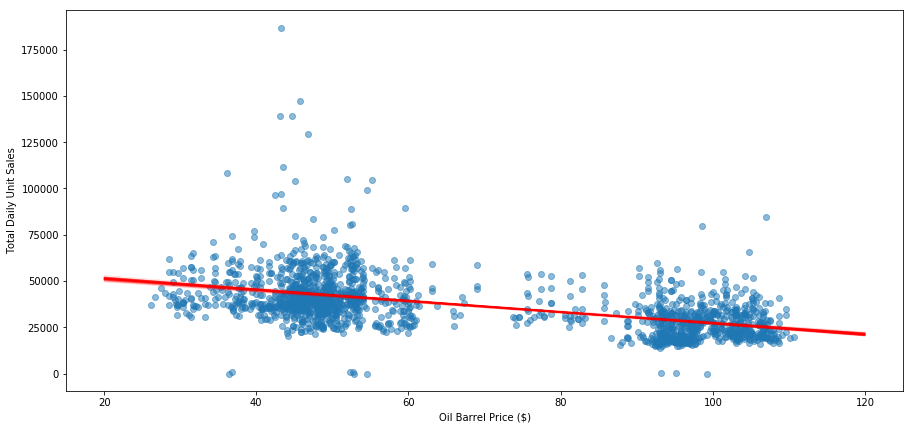

In [13]:
# Make a scatter plot of the data
fig, ax1 = plt.subplots(figsize=(15, 7))

color = 'tab:blue'
ax1.set_xlabel('Oil Barrel Price ($)')
ax1.set_ylabel('Total Daily Unit Sales')
ax1.scatter(oil_prices, unit_sales, color=color, alpha=0.5)

# Generate x-values for bootstrap lines
x = np.array([20, 120])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps[i] * x + bs_intercept_reps[i], linewidth=0.5, alpha=0.2, color='red')

plt.show()